In [561]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv


In [562]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [563]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

%matplotlib inline

# **Import DATA**

In [564]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [565]:
df_train['train'] = 1 # помечаем где у нас трейн
df_test['train'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

Подробнее по признакам:

1. City: Город
2. Cuisine Style: Кухня
3. Ranking: Ранг ресторана относительно других ресторанов в этом городе
4. Price Range: Цены в ресторане в 3 категориях
5. Number of Reviews: Количество отзывов
6. Reviews: 2 последних отзыва и даты этих отзывов
7. URL_TA: страница ресторана на 'www.tripadvisor.com'
8. ID_TA: ID ресторана в TripAdvisor
9. Rating: Рейтинг ресторана

# Обработка

## **1. Первичная обработка данных**
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, даже отсутствие информации может быть важным признаком!
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак

In [566]:
# Рассмотрим названия колонок во избежании дальнейших трудностей при обработке данных:
data.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'train', 'Rating'],
      dtype='object')

In [567]:
# Названия колонок корректны, но для большего удобства сведем все названия к нижнему регистру:
dt = data.copy()
dt.rename(columns={'Restaurant_id':'res_id','City':'city','Cuisine Style':'cuis_style',
                  'Ranking':'rank','Price Range':'price','Number of Reviews':'num_rev',
                  'Reviews':'review','Rating':'rating',
                  'URL_TA':'url','ID_TA':'idta'}, inplace=True)

In [568]:
# Посмотрим на размер массива, и предварительную информацию о нашем датасете.
print(f'Размер датасета: {dt.shape[0]} - строк, {dt.shape[1]} - колонок')

Размер датасета: 50000 - строк, 11 - колонок


In [569]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   res_id      50000 non-null  object 
 1   city        50000 non-null  object 
 2   cuis_style  38410 non-null  object 
 3   rank        50000 non-null  float64
 4   price       32639 non-null  object 
 5   num_rev     46800 non-null  float64
 6   review      49998 non-null  object 
 7   url         50000 non-null  object 
 8   idta        50000 non-null  object 
 9   train       50000 non-null  int64  
 10  rating      50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [570]:
# убираем не нужные для модели признаки
dt.drop(['res_id','url','idta',], axis = 1, inplace=True)

In [571]:
# Посмотрим на количество отсутствующих значений и их процентное соотношение:

def table(df):
    x = pd.DataFrame()
    x['Всего NaN'] = df.isna().sum()
    x['% NaN'] = round((x['Всего NaN'] / df.shape[0])*100, 2)
    return x.sort_values('% NaN', ascending=False)

table(dt)

,Всего NaN,% NaN
price,17361,34.72
cuis_style,11590,23.18
num_rev,3200,6.40
city,0,0.00
rank,0,0.00
review,2,0.00
train,0,0.00
rating,0,0.00


Итак в 4 столбцах нашего датасета есть пропущенные значения. 

Прежде чем приступить к непосредственному анализу данных их очистки и приведению к удобному для дальнейшей обработки виду, их следует разделить. Признаки в датасете можно разделить на две категории: количественные(числовые) и номинативные(категориальные). Для каждой категории у нас будут определенные методы анализа и восстановления данных.

In [572]:
categorical_col = [
    col for col in dt.columns if dt[col].dtype.name == 'object']
numerical_col = [
    col for col in dt.columns if dt[col].dtype.name != 'object']

print(f'Количество категориальных признаков: {len(categorical_col)}')
print(categorical_col)
print(60*'==')
print(f'Количество числовых признаков: {len(numerical_col)}')
print(numerical_col)

Количество категориальных признаков: 4
['city', 'cuis_style', 'price', 'review']
Количество числовых признаков: 4
['rank', 'num_rev', 'train', 'rating']


In [573]:
# Рассмотрим количественные признаки:
dt[numerical_col].describe()

,rank,num_rev,train,rating
count,50000.000000,46800.000000,50000.000000,50000.000000
mean,3664.427520,124.471197,0.800000,3.194430
std,3700.092452,294.114345,0.400004,1.705453
min,1.000000,2.000000,0.000000,0.000000
25%,972.000000,9.000000,1.000000,3.000000
50%,2278.000000,33.000000,1.000000,4.000000
75%,5241.000000,115.000000,1.000000,4.500000
max,16444.000000,9660.000000,1.000000,5.000000


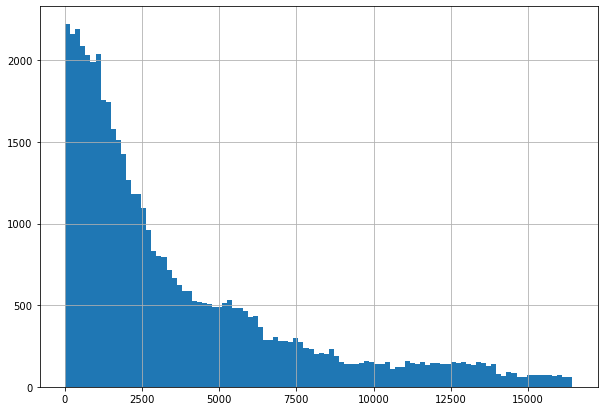

In [574]:
plt.rcParams['figure.figsize'] = (10,7)
dt['rank'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

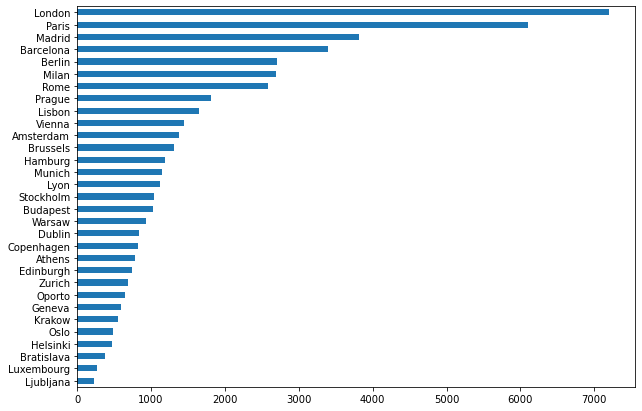

In [575]:
dt['city'].value_counts(ascending=True).plot(kind='barh')

Посмотрим, как изменится распределение в большом городе:

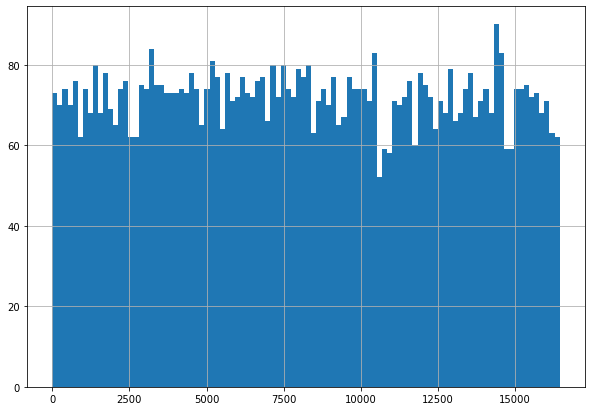

In [576]:
dt['rank'][dt['city'] =='London'].hist(bins=100)

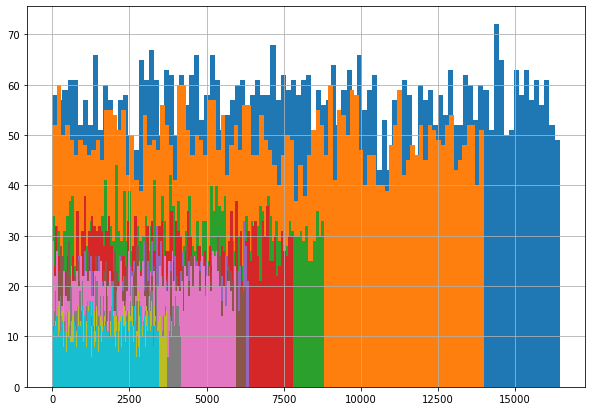

In [577]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

## 2. Обработка категориальных признаков:

In [578]:
def tokenizer(col):
    # Получим список всех значений в данном признаке:
    vocab = []
    for row in dt[col]:
        vocab.append(str(row))
    # Создаем список токенов:        
    token = sorted(set(vocab))
    # Задаем словарь с числовым значением для каждого токена:
    dictionary = {elem:ind for ind, elem in enumerate(token)}
    # Применяем словарь к исходной колонке:
    return dictionary

### Обработка NAN
![](http://)Создадим столбцы с информацией о том, где были пропуски.

In [579]:
dt['cuis_nan'] = pd.isna(dt['cuis_style']).astype('uint8')
dt['price_nan'] = pd.isna(dt['price']).astype('uint8')

### Price:

Определим все возможные значения в столбце и присвоим им числовые определители.

In [580]:
dt['price'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: price, dtype: int64

In [581]:
# Создадим числовые признаки  для колонки Price:
token = tokenizer('price')
# Применим полученный словарь к столбцу
dt = dt.replace({'price': token})

In [582]:
# Заполним Nan
dt['price'].fillna(3, inplace=True)

### Number of reviews:

Рассмотрим количество отзывов по городам:

In [583]:
num_rev_per_city = dt.groupby(['city'])['num_rev'].sum().sort_values(ascending=True)

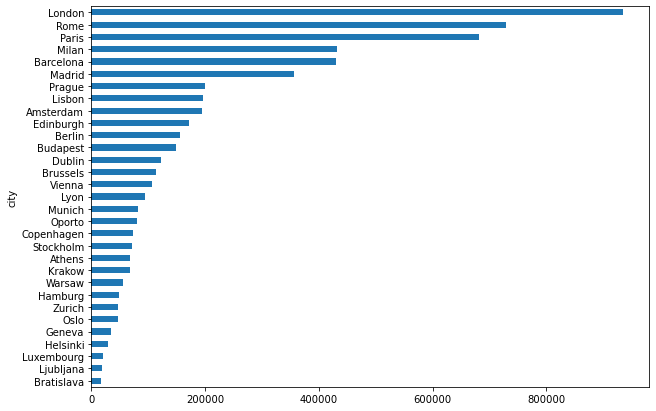

In [584]:
num_rev_per_city.plot(kind='barh')

Добавим признак ранга относительно количества отзывов для каждого города:

In [585]:
dt['rev_per_city'] = dt['city'].apply(lambda row: num_rev_per_city[row])
dt['rel_rank'] = dt['rank'] / dt['rev_per_city']
dt.drop(['rev_per_city'], axis = 1, inplace=True)

### City:

In [586]:
# Cоздадим словарь столиц европейских стран нашего датасета
capitals = {'London':1,'Paris':1,'Madrid':1,'Barcelona':0,'Berlin':1,'Milan':0,'Rome':1,'Prague':1,        
'Lisbon':1,'Vienna':1, 'Amsterdam':1,'Brussels':1,'Hamburg':0,'Munich':0,'Lyon':0,'Stockholm':1,     
'Budapest': 1,'Warsaw':1,'Dublin':1,'Copenhagen':1,'Athens':1,'Edinburgh':0,'Zurich':0,'Oporto':0,         
'Geneva':0,'Krakow':0,'Oslo':1,'Helsinki':1,'Bratislava':1,'Luxembourg':1,'Ljubljana':1}
# Создадим новый признак является ли город столицей страны:
dt['capital'] = dt['city']
# Применим словарь к новому признаку
dt = dt.replace({'capital': capitals})

In [587]:
token = tokenizer('city')
# Применим полученный словарь к столбцу
dt = dt.replace({'city': token})

In [588]:
# Создадим признак количества ресторанов для каждого города
rest_in_city = dt.groupby('city')['rank'].count().to_dict()
dt['rest_count'] = dt['city'].map(rest_in_city)

### Number of review

In [589]:
nan = dt['num_rev'].isna().sum()
print(f'Количество пропущенных значений: {nan}')

Количество пропущенных значений: 3200


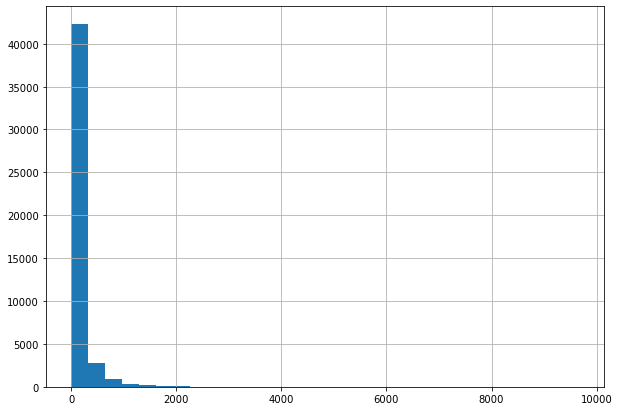

In [590]:
plt.rcParams['figure.figsize'] = (10,7)
dt['num_rev'].hist(bins=30)

In [591]:
#Заполним пропущенные значения нулями
dt['num_rev'] = dt['num_rev'].fillna(0)

### Reviews:

In [592]:
# заполним пропуски неопределенным значением [[], []] и создадим новый признак
# где есть пропуски в review 
dt['review'] = dt['review'].fillna('[[], []]')
dt['review_nan'] = (dt['review']=='[[], []]').astype('float64')

In [593]:
# вытащим дату из ревью и создадим новые критерии
dt['date'] = dt['review'].str.findall('\d+/\d+/\d+')
dt['len_date'] = dt['date'].apply(lambda x: len(x))

In [594]:
# создадим признак количества дней с последнего отзыва до текущей даты
day_to_now = []

for i in dt['date']:
    if len(i) == 0:
        day_to_now.append(0)
    else:
        day_to_now.append((datetime.datetime.now() - pd.to_datetime(i).max()).days)

dt['day_to_now'] = day_to_now

In [595]:
# создадим признак количества дней между отзывами
# если отзыв один то значение 0 то же и для больших значений
review_between = []

for i in dt['date']:
    if len(i) == 2:
        review_between.append((pd.to_datetime(i).max() - pd.to_datetime(i).min()).days)
    else:
        review_between.append(0)
        
dt['review_between'] = review_between

In [596]:
# обработаем сами отзывы, очистим мусор и создадим три списка:
# review - очищенная строка отзыва (понадобится в будущем)
# num_review - список отзывов для каждого ресторана
# review_list - список списков слов в отзыве для поиска положительных и 
# негативных отзывов

review = []
num_review = []
review_list = []

for row in dt['review']:
    row = str(row).replace("'",'"').replace('[["','').replace('", "',' $ ')
    row = str(row).replace('"], ["','|')
    row = row.lower()
    ind_num = row.find("|")
    row = row[:ind_num]
    row = str(row).replace('[[], []','None')
    rew = row.split('$')
    num_review.append(rew)
    row = str(row).replace('$ ','').replace('!','').replace(',','').replace('...','').replace('.','')
    row = str(row).replace(' - ',' ').replace(' :','').replace('"','').replace(' & ',' ').replace(' :)','')
    review.append(row)
    row = row.split(' ')
    review_list.append(row)

In [597]:
# создаим список количества отзывов для ресторана
numbers = []

for i in num_review:
    if 'None' in i:
        numbers.append(int(0))
    else:
        numbers.append(int(len(i)))

In [598]:
# задаем новые признаки
dt['number_review'] = numbers
dt['review'] = review

In [599]:
# зададим пару списков с набором положительных и отрицательных слов, которые
# могут содержаться в отзывах

good_rew = ['good', 'fine', 'better', 'exquisite', 'best', 'supper', 'great', 
            'welcome', 'nice', 'tasty', 'high quality', 'low price', 'magnificent',
           'delicious', 'recommended', 'excellent', 'amazing', 'perfect', 'treasure', 
            'yummy', 'wonderful', 'breathtaking', 'ok', 'okay', 'not bad']

bad_rew = ['nightmare', 'worst', 'bad','sad', 'disgusting', 'rip', 'bad', 'disappointing', 'sadly', 'unclear',
           'dull', 'terrible', 'forget it', 'worth', 'awful', 'avoid', 'not good', 'slow', 'serious attention', 
           'worse', 'not fantastic','horrible', 'tragic', 'avoid', 'unfortunate']

In [600]:
# 0 - нет или неопределенный комментарий по поводу ресторана
# 1 - положительный комментарий по поводу ресторана
# 2 - отрицательный комментарий по поводу ресторана

# Туповатый способ определить тип комментария: считаем вхождение положительный и
# негативных слов в строку, их разность определяет тип комментария
rev_dict = []

for i in review_list:
    good_review=list(set(good_rew) & set(i))
    bad_review=list(set(bad_rew) & set(i))
    result = len(good_review) - len(bad_review)
    if result == 0:
        rev_dict.append(0)
    elif result > 0:
        rev_dict.append(1)
    else:
        rev_dict.append(2)
        
dt['review'] = rev_dict

### Raiting:

In [601]:
# ничего интересного 0 соответствует тестовым значениям

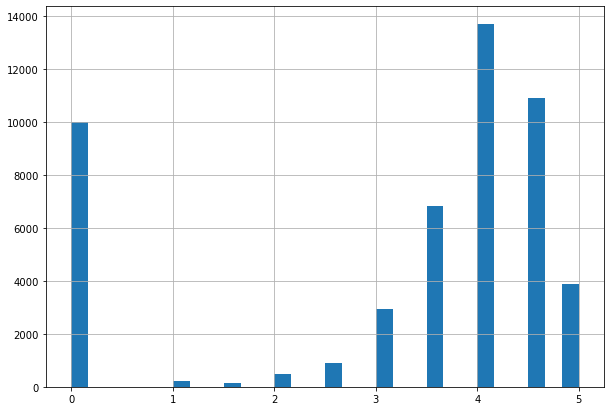

In [602]:
plt.rcParams['figure.figsize'] = (10,7)
dt['rating'].hist(bins=30)

In [603]:
def round_of_rating(number):
    return np.round(number * 2) / 2

# Cuisine

* Колонка Cuisine Style:
* Количество пропущенных значений признака: 11590
* Процент пропущенных значений признака: 23.18 %

Пропущенных значений слишком много, поэтому заполним отсутсующие значения признака новым.

In [604]:
# заполним пропущенные значения параметром other и отберем топ 30 кухонь для обработки
dt['cuis_style'].fillna('other', inplace = True)
df = dt['cuis_style'].value_counts().head(30)
df

other                                                              11590
['Italian']                                                         1332
['French']                                                          1019
['Spanish']                                                          860
['French', 'European']                                               503
['Cafe']                                                             500
['Pizza']                                                            454
['Italian', 'Pizza']                                                 422
['Chinese']                                                          418
['European', 'Portuguese']                                           415
['Mediterranean']                                                    311
['Bar', 'Pub']                                                       307
['Mediterranean', 'Spanish']                                         293
['Vegetarian Friendly']                            

In [605]:
# создадим два новых признака 
# cuis_num - количество кухонь для ресторана
# cuis_style - тип кухни если не входит в топ 30 получает маркер other

cuis_style = []
cuis_num = []

for row in dt['cuis_style']:
    if row in df:
        row = str(row).replace("['","").replace("']","").replace("', '","|")
        cuis_style.append(row)
    else:
        cuis_style.append('other')
    row = row.split('|')
    cuis_num.append(len(row))
    
dt['cuis_style'] = cuis_style
dt['cuis_num'] = cuis_num

In [606]:
# Создадим числовые признаки  для колонки Price:
token = tokenizer('cuis_style')
# Применим полученный словарь к столбцу
dt = dt.replace({'cuis_style': token})

### Корреляционный анализ

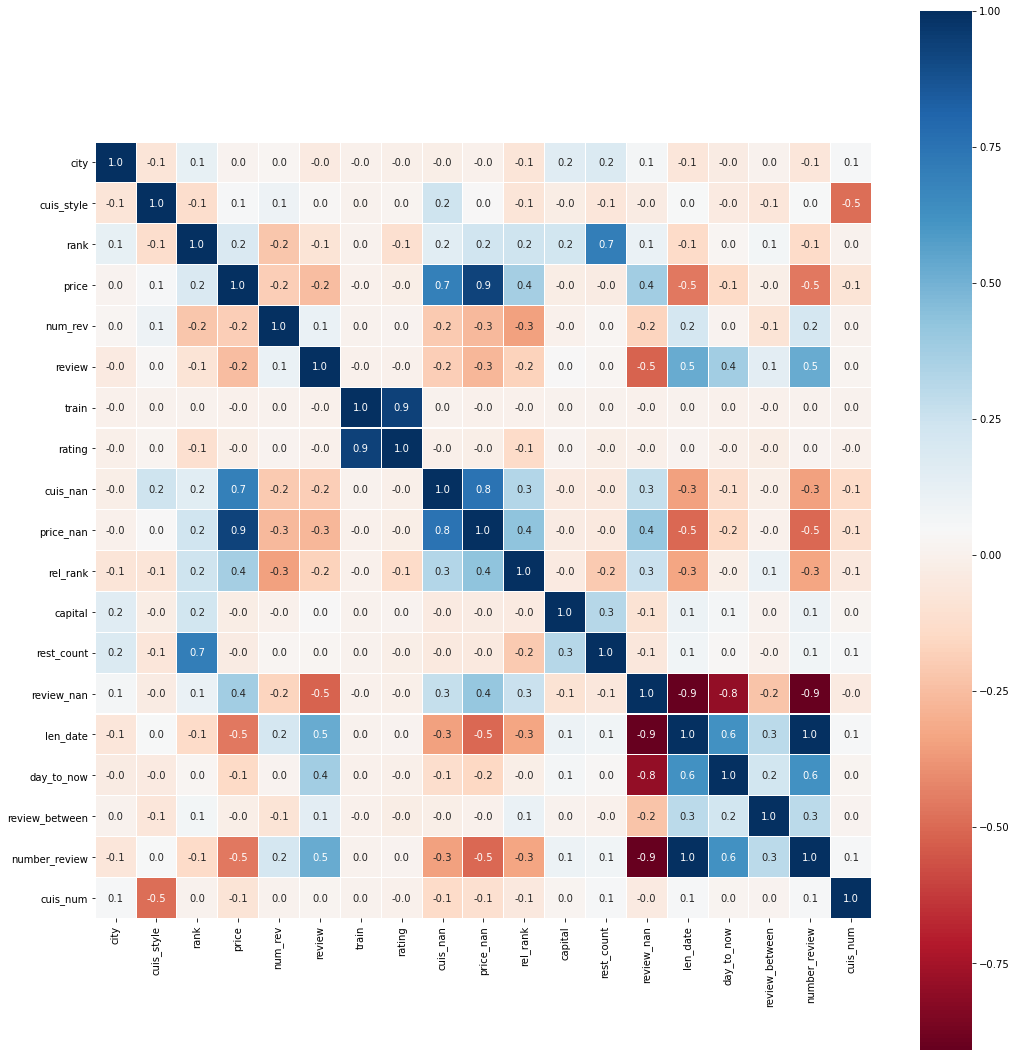

In [607]:
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(dt.corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()

Столбцы 'cuis_nan','price_nan','review_nan' сильно коррелируют с родительскими столбцами поэтому смысла в них нет удаляем. Столбец date удаляем так как он не несет более никакой полезной информации.

In [608]:
dt.drop(['date','cuis_nan','price_nan','review_nan'], axis = 1, inplace=True)

Оценим распределение величин в нашем датасете

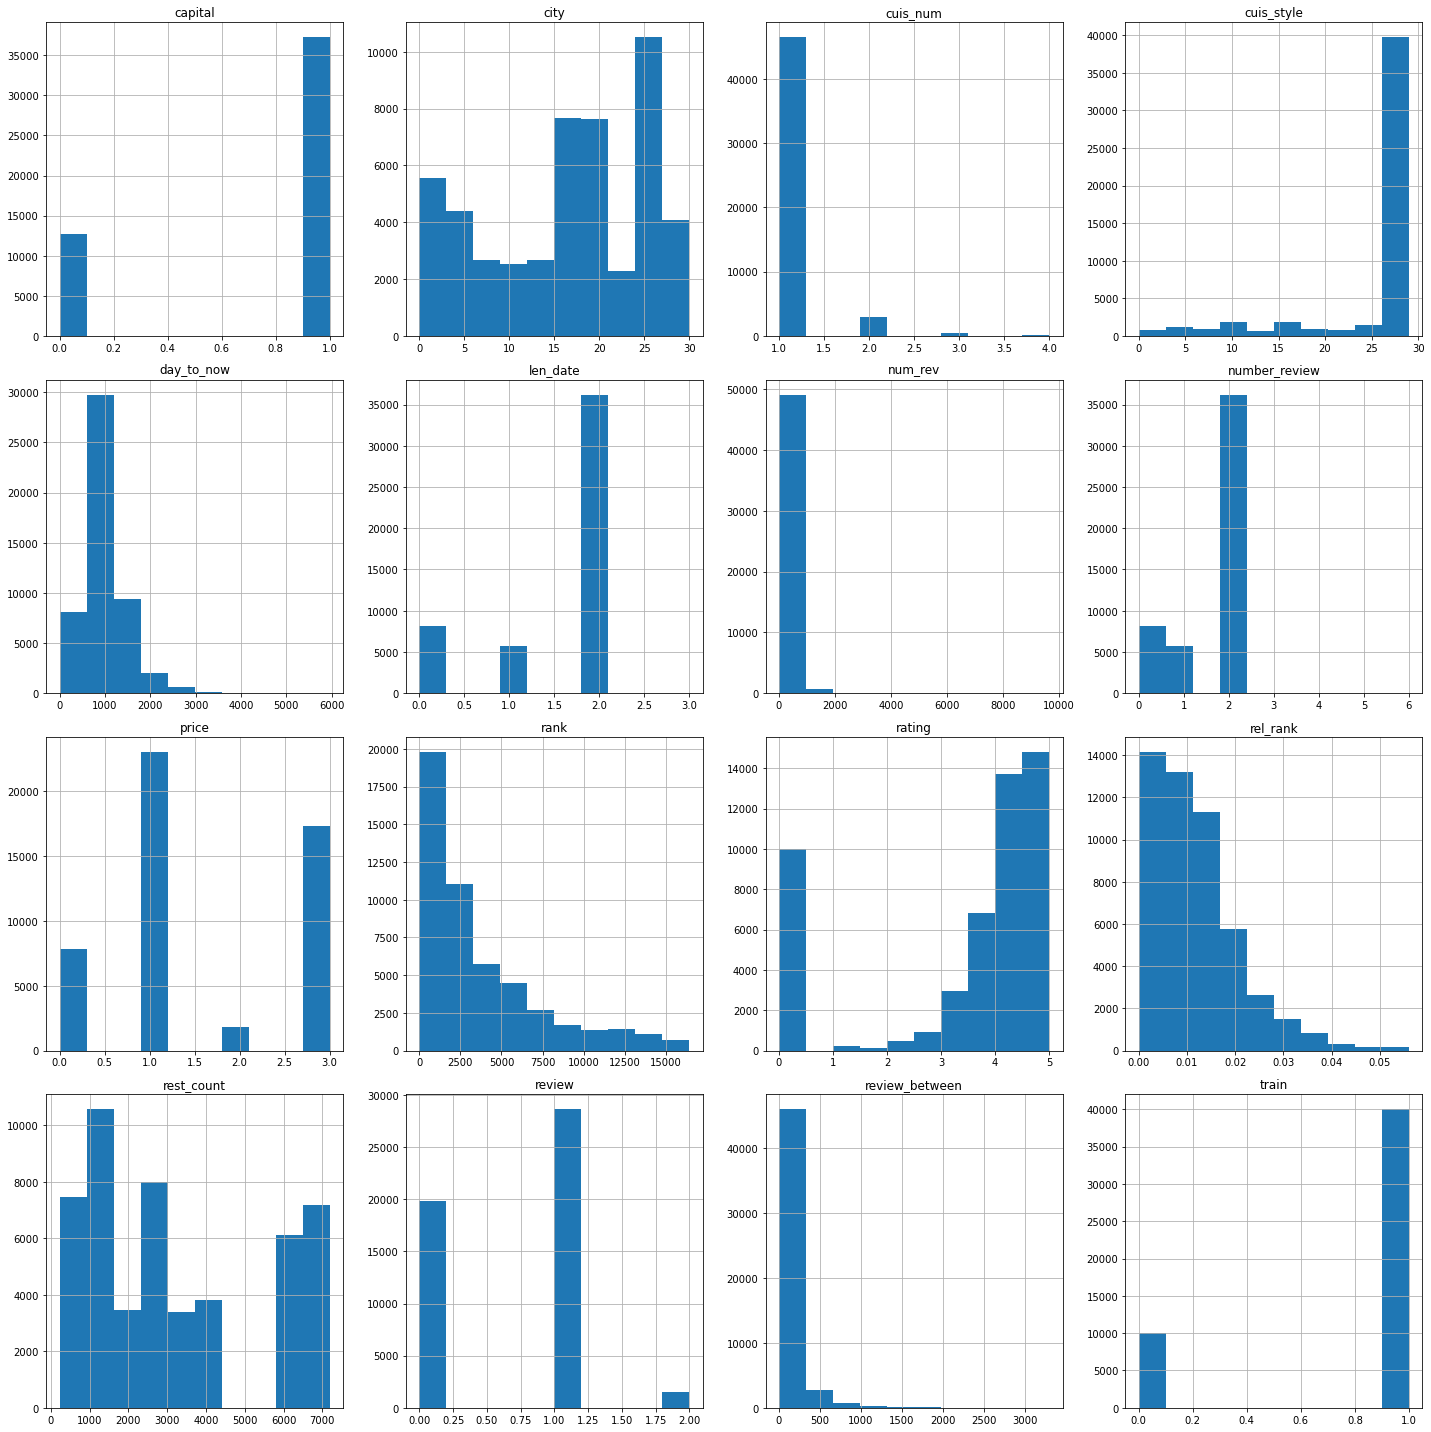

In [609]:
dt[dt.columns].hist(figsize=(20, 20), bins=10);
plt.tight_layout()

### Нормализуем признаки:

In [610]:
# в датасете величины имеют сильный разброс от единиц до нескольких тысяч
# для корректной работы алгоритма следует привести их к соответствующим значениям

def norn(col):
    xnorm = []
    xmax = dt[col].describe()[-1]
    xmin = dt[col].describe()[3]
    for x in dt[col]:
        xnorm.append((x - xmin)/(xmax - xmin))
    dt[col] = xnorm
    return dt[col]

In [611]:
for col in dt.columns:
    if col != 'rating':
        norn(col)
    else:
        pass

In [612]:
dt.sample(10)

,city,cuis_style,rank,price,num_rev,review,train,rating,rel_rank,capital,rest_count,len_date,day_to_now,review_between,number_review,cuis_num
43887,0.000000,1.000000,0.066715,0.333333,0.001760,0.5,1.0,5.0,0.101102,1.0,0.164969,0.666667,0.159476,0.043993,0.333333,0.000000
29279,0.533333,1.000000,0.305480,0.000000,0.006004,0.5,1.0,4.0,0.096017,1.0,1.000000,0.666667,0.175592,0.028823,0.333333,0.000000
32045,0.066667,1.000000,0.388858,1.000000,0.000207,0.0,1.0,3.5,0.265788,0.0,0.455171,0.333333,0.195065,0.000000,0.166667,0.000000
10368,0.533333,1.000000,0.536338,0.333333,0.003209,0.0,1.0,3.5,0.168579,1.0,1.000000,0.666667,0.206144,0.003034,0.333333,0.000000
33250,0.166667,1.000000,0.102293,1.000000,0.002588,0.0,1.0,4.0,0.263597,1.0,0.156649,0.666667,0.170891,0.178398,0.333333,0.000000
26347,0.866667,0.586207,0.274767,0.333333,0.001242,0.0,1.0,4.5,0.110744,1.0,0.339550,0.000000,0.000000,0.000000,0.000000,0.333333
26998,0.066667,1.000000,0.047741,0.333333,0.015528,0.5,1.0,4.5,0.032651,0.0,0.455171,0.666667,0.159812,0.016990,0.333333,0.000000
26559,0.633333,1.000000,0.401265,0.333333,0.000207,0.0,1.0,3.5,0.329750,1.0,0.515134,0.000000,0.000000,0.000000,0.000000,0.000000
30216,0.100000,1.000000,0.198626,1.000000,0.000000,0.5,1.0,5.0,0.373974,1.0,0.356190,0.333333,0.276314,0.000000,0.166667,0.000000
11366,0.066667,1.000000,0.065012,0.333333,0.006108,0.5,1.0,4.5,0.044455,0.0,0.455171,0.666667,0.165687,0.006068,0.333333,0.000000


### Разбиваем датасет на тренировочный и тестовый

In [613]:
train_data = dt.query('train == 1').drop(['train'], axis=1)
test_data = dt.query('train == 0').drop(['train'], axis=1)

y = train_data.rating.values         
X = train_data.drop(['rating'], axis=1)

In [614]:
# используем train_test_split для разбивки тестовых данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [615]:
# проверяем размеры массивов
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 15), (40000, 15), (40000, 14), (32000, 14), (8000, 14))

### Model

In [616]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [617]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [618]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [619]:
y_pred_old = y_pred.copy()
y_pred = round_of_rating(y_pred) 

In [620]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred),  metrics.mean_absolute_error(y_test, y_pred_old) )

MAE: 0.173125 0.20342875


In [621]:
#Вычисляем коэффициент детерминации:
R_2 = metrics.r2_score(y_test, y_pred)
print(R_2)

0.744978348727847


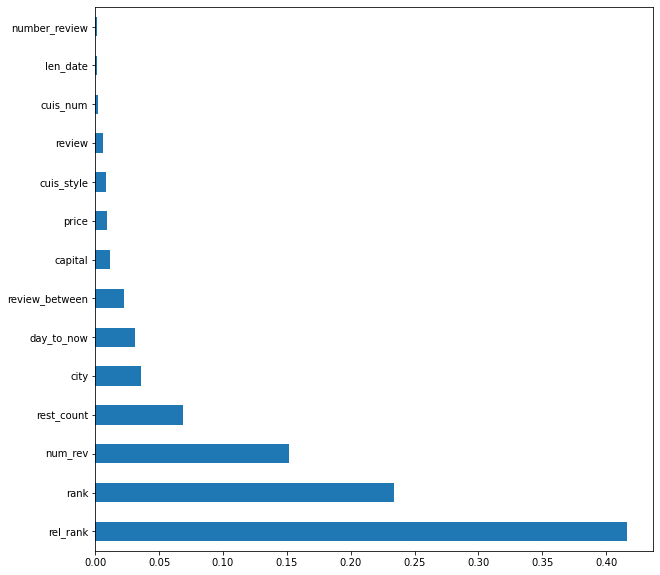

In [622]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh');

# Submission

In [623]:
test_data.sample(10)

,city,cuis_style,rank,price,num_rev,review,rating,rel_rank,capital,rest_count,len_date,day_to_now,review_between,number_review,cuis_num
3913,0.600000,1.000000,0.012832,0.333333,0.015010,0.5,0.0,0.040258,0.0,0.129680,0.666667,0.289072,0.131068,0.333333,0.0
8374,0.933333,1.000000,0.041294,0.333333,0.007143,0.0,0.0,0.113726,1.0,0.175154,0.666667,0.216384,0.021238,0.333333,0.0
6890,0.666667,1.000000,0.076993,0.333333,0.014803,0.5,0.0,0.052410,0.0,0.354612,0.666667,0.161155,0.055522,0.333333,0.0
2810,0.200000,1.000000,0.092380,1.000000,0.000621,0.0,0.0,0.182847,1.0,0.114618,0.666667,0.320631,0.026092,0.333333,0.0
2128,0.333333,1.000000,0.083744,1.000000,0.000725,0.0,0.0,0.721901,0.0,0.052790,0.000000,0.000000,0.000000,0.000000,0.0
815,0.533333,1.000000,0.410874,0.000000,0.028882,0.5,0.0,0.129144,1.0,1.000000,0.666667,0.159980,0.002124,0.333333,0.0
8323,0.866667,0.827586,0.205437,1.000000,0.003313,0.0,0.0,0.082802,1.0,0.339550,0.000000,0.000000,0.000000,0.000000,0.0
5754,0.000000,1.000000,0.035699,0.000000,0.006315,0.5,0.0,0.054133,1.0,0.164969,0.666667,0.159812,0.000607,0.333333,0.0
2198,0.700000,0.620690,0.053944,0.333333,0.005487,0.5,0.0,0.192372,0.0,0.132406,0.666667,0.190868,0.015473,0.333333,1.0
8276,0.533333,1.000000,0.557319,1.000000,0.000000,0.0,0.0,0.175174,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [624]:
test_data = test_data.drop(['rating'], axis=1)

In [625]:
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
5,id_5,4.5
6,id_6,4.5
7,id_7,2.0
8,id_8,2.0
9,id_9,3.5


In [626]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [627]:
predict_submission = np.round(predict_submission, 1)

In [628]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.1
1,id_1,4.2
2,id_2,4.6
3,id_3,4.3
4,id_4,4.3
5,id_5,4.3
6,id_6,3.2
7,id_7,2.6
8,id_8,4.1
9,id_9,4.7
